In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import gc

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color = sns.color_palette()
sns.set_style("darkgrid")

In [2]:
def change_dtype(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
    return df

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

__Using UCF data for site_id 0__ 

Special thanks to <a href="https://www.kaggle.com/gunesevitan/ashrae-ucf-spider-and-eda-full-test-labels/data"> Gunes</a> for this awesome work

In [3]:
# load site 0 data
ext_df = pd.read_pickle('site0.pkl') 
ext_df['meter_reading'] = ext_df.meter_reading_scraped
ext_df.drop(['meter_reading_original','meter_reading_scraped'], axis=1, inplace=True)
ext_df.fillna(0, inplace=True)
ext_df.loc[ext_df.meter_reading < 0, 'meter_reading'] = 0
ext_df = ext_df[ext_df.timestamp.dt.year > 2016]
print(len(ext_df))

2260080


In [4]:
ext_df.sample(5)

,building_id,meter,timestamp,meter_reading
2457633,21,0,2018-03-23 01:00:00,56.106448
2998269,21,0,2018-09-13 16:00:00,117.536866
2226660,78,0,2018-01-07 10:00:00,653.073596
2840404,46,0,2018-07-24 16:00:00,76.590081
3262610,37,0,2018-12-08 01:00:00,181.902296


In [5]:
df_build = pd.read_csv('building_metadata.csv')
df_weather_train = pd.read_csv('weather_train.csv')
df_train = pd.read_csv('train.csv')
df_weather_test =  pd.read_csv('weather_test.csv')

In [6]:
ucf_year = [2017, 2018] # ucf data year used in train
#Deleting sioi 0 data for 2016
bids = ext_df.building_id.unique()
df_train = df_train[df_train.building_id.isin(bids) == False]

ext_df = ext_df[ext_df.timestamp.dt.year.isin(ucf_year)]

df_train = pd.concat([df_train, ext_df])
df_train.reset_index(inplace=True)

df_weather_train = pd.concat([df_weather_train, df_weather_test])
df_weather_train.reset_index(inplace=True)

In [7]:
del df_weather_test, ext_df
gc.collect()

22

In [8]:
df_train = change_dtype(df_train)
df_weather_train = change_dtype(df_weather_train)

df_train = reduce_mem_usage(df_train)
df_weather_train = reduce_mem_usage(df_weather_train)
df_build= reduce_mem_usage(df_build)

gc.collect()

Mem. usage decreased to 387.76 Mb (52.5% reduction)
Mem. usage decreased to 10.74 Mb (66.2% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


22

In [9]:
df_train['date'] = df_train['timestamp'].dt.date
df_train['meter_reading_log1p'] = np.log1p(df_train['meter_reading'])

In [10]:
def plot_date_usage(train_df, meter=0, building_id=0):
    fig = plt.figure(figsize=(16, 8))
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    sns.lineplot(x=train_temp_df_meter['date'], y=train_temp_df_meter['meter_reading_log1p'])
    plt.show()

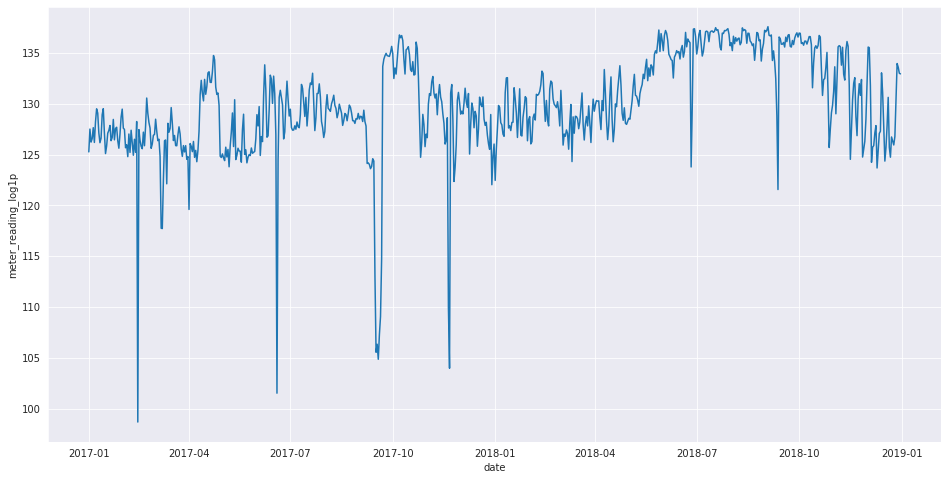

In [11]:
plot_date_usage(df_train, meter=0, building_id=0)

### Removing data of site 0 till 20th of May 2016 for electricity meter

In [12]:
df_train = df_train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

__As we already know weather has lot's of NaNs, We will fill Nan using Interpolation__

In [3]:
def fill_weather(df):
    df = df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
    return df

In [14]:
df_weather_train = fill_weather(df_weather_train)

In [15]:
df_weather_train.groupby('site_id').apply(lambda group: group.isna().sum())

,index,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,26050,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,25996,25996,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,25187,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0


We can see that some sites dosen't have any information for some of the features hence we are still getting NaNs

In [16]:
def pre_preprocess_data(df, test=False):
    
    """
    Preparing final dataset with all features.
    """
#     df.square_feet = np.log1p(df.square_feet)
    
    if not test:
        df.sort_values("timestamp", inplace=True)
        df.reset_index(drop=True, inplace=True)
    
#     holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
#                 "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
#                 "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
#                 "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
#                 "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
#                 "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
#                 "2019-01-01"]
    
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek
#     df["is_holiday"] = (df.timestamp.dt.date.astype("str").isin(holidays)).astype(int)

    df_group = df.groupby('building_id')['meter_reading_log1p']
    building_median = df_group.median().astype(np.float16)
    df['building_median'] = df['building_id'].map(building_median)
    
    del df_group
    gc.collect()

    return df, building_median

In [17]:
df_train, building_median = pre_preprocess_data(df_train)

In [ ]:
picfile = open('buildings.pkl', 'wb')
pickle.dump(building_median, picfile)
picfile.close()

In [18]:
df_train.head()

,index,building_id,meter,timestamp,meter_reading,date,meter_reading_log1p,hour,weekend,month,dayofweek,building_median
0,103,105,0,2016-01-01,23.303600,2016-01-01,3.190624,0,4,1,4,4.332031
1,1577,1123,0,2016-01-01,27.444000,2016-01-01,3.347937,0,4,1,4,3.533203
2,1576,1122,1,2016-01-01,0.000000,2016-01-01,0.000000,0,4,1,4,4.144531
3,1575,1122,0,2016-01-01,70.580002,2016-01-01,4.270816,0,4,1,4,4.144531
4,1574,1121,2,2016-01-01,1570.310059,2016-01-01,7.359665,0,4,1,4,5.101562


In [4]:
category_cols = ['building_id', 'site_id', 'primary_use']
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'weekend',
    'building_median'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed']

In [5]:
from sklearn.preprocessing import LabelEncoder

In [21]:
le = LabelEncoder()
df_build.primary_use = le.fit_transform(df_build.primary_use)

In [22]:
def create_X_y(train_df, target_meter):
    
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(df_build, on='building_id', how='left')
    target_train_df = target_train_df.merge(df_weather_train, on=['site_id', 'timestamp'], how='left')
    target_train_df.square_feet = np.log1p(target_train_df.square_feet)
    
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values
    
    del target_train_df
    gc.collect()
    return X_train, y_train

In [6]:
import lightgbm as lgb
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
random.seed(12)

In [24]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [7]:
folds = 5
num_rounds=1000
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
oof_total = 0

### Traning Model for meter 0

target_meter 0 (12992101, 15)
cat_features [12, 13, 14]
train 10393680 valid 2598421
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.712079	valid_1's l2: 0.72187
[40]	training's l2: 0.438312	valid_1's l2: 0.483635
[60]	training's l2: 0.384046	valid_1's l2: 0.445374
[80]	training's l2: 0.361598	valid_1's l2: 0.442077
Early stopping, best iteration is:
[70]	training's l2: 0.37095	valid_1's l2: 0.44184
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.370950363487402)]), 'valid_1': OrderedDict([('l2', 0.4418396456899522)])})
train 10393681 valid 2598420
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.7378	valid_1's l2: 0.643597
[40]	training's l2: 0.466463	valid_1's l2: 0.372888
[60]	training's l2: 0.4112	valid_1's l2: 0.320096
[80]	training's l2: 0.387744	valid_1's l2: 0.304858
[100]	training's l2: 0.367216	valid_1's l2: 0.300076
[120]	training's l2

10

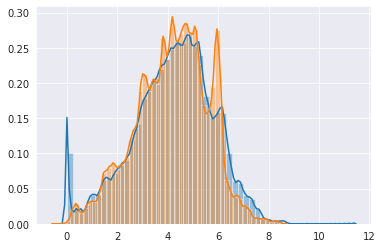

In [26]:
target_meter = 0
X_train, y_train = create_X_y(df_train, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=num_rounds, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof0 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof0 * len(y_train)

del X_train, y_train
gc.collect()

target_meter 1 (4434667, 15)
cat_features [12, 13, 14]
train 3547733 valid 886934
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.92126	valid_1's l2: 3.10636
[40]	training's l2: 2.15206	valid_1's l2: 2.10957
[60]	training's l2: 1.90595	valid_1's l2: 1.8772
[80]	training's l2: 1.78546	valid_1's l2: 1.79445
[100]	training's l2: 1.71604	valid_1's l2: 1.75368
[120]	training's l2: 1.67075	valid_1's l2: 1.7343
[140]	training's l2: 1.63674	valid_1's l2: 1.71921
[160]	training's l2: 1.61094	valid_1's l2: 1.70919
[180]	training's l2: 1.58651	valid_1's l2: 1.70548
[200]	training's l2: 1.56767	valid_1's l2: 1.69903
[220]	training's l2: 1.55287	valid_1's l2: 1.69641
[240]	training's l2: 1.53877	valid_1's l2: 1.69459
[260]	training's l2: 1.52539	valid_1's l2: 1.69439
Early stopping, best iteration is:
[246]	training's l2: 1.5351	valid_1's l2: 1.693
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.5350978188

10

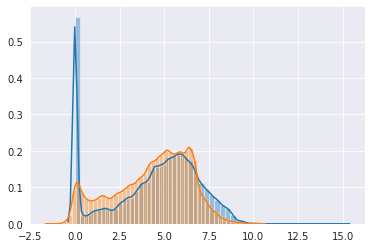

In [27]:
target_meter = 1
X_train, y_train = create_X_y(df_train, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=num_rounds,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof1 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof1 * len(y_train)

del X_train, y_train
gc.collect()

target_meter 2 (2708713, 15)
cat_features [12, 13, 14]
train 2166970 valid 541743
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.67207	valid_1's l2: 3.21723
[40]	training's l2: 1.9647	valid_1's l2: 2.57634
[60]	training's l2: 1.79944	valid_1's l2: 2.47248
[80]	training's l2: 1.71887	valid_1's l2: 2.44126
[100]	training's l2: 1.66938	valid_1's l2: 2.42819
[120]	training's l2: 1.63293	valid_1's l2: 2.41886
[140]	training's l2: 1.60431	valid_1's l2: 2.41515
[160]	training's l2: 1.57679	valid_1's l2: 2.41244
[180]	training's l2: 1.55456	valid_1's l2: 2.41117
[200]	training's l2: 1.5356	valid_1's l2: 2.40715
[220]	training's l2: 1.51925	valid_1's l2: 2.40309
[240]	training's l2: 1.50314	valid_1's l2: 2.39863
[260]	training's l2: 1.48927	valid_1's l2: 2.3954
[280]	training's l2: 1.47719	valid_1's l2: 2.39117
[300]	training's l2: 1.46596	valid_1's l2: 2.38909
[320]	training's l2: 1.45364	valid_1's l2: 2.38704
[340]	training's l2: 1.44377	valid

10

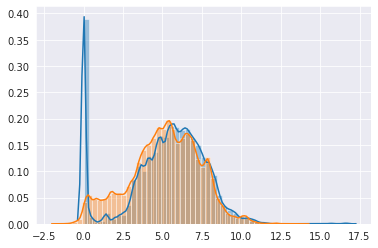

In [28]:
target_meter = 2
X_train, y_train = create_X_y(df_train, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=num_rounds, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof2 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof2 * len(y_train)

del X_train, y_train
gc.collect()

target_meter 3 (1264037, 15)
cat_features [12, 13, 14]
train 1011229 valid 252808
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 3.60832	valid_1's l2: 4.34412
[40]	training's l2: 2.60222	valid_1's l2: 3.25881
[60]	training's l2: 2.25269	valid_1's l2: 2.84837
[80]	training's l2: 2.10487	valid_1's l2: 2.6674
[100]	training's l2: 2.02705	valid_1's l2: 2.58445
[120]	training's l2: 1.97836	valid_1's l2: 2.53033
[140]	training's l2: 1.93732	valid_1's l2: 2.49493
[160]	training's l2: 1.90521	valid_1's l2: 2.47274
[180]	training's l2: 1.87942	valid_1's l2: 2.45419
[200]	training's l2: 1.85892	valid_1's l2: 2.44611
[220]	training's l2: 1.84262	valid_1's l2: 2.43842
[240]	training's l2: 1.82902	valid_1's l2: 2.4321
[260]	training's l2: 1.81466	valid_1's l2: 2.42955
[280]	training's l2: 1.80295	valid_1's l2: 2.42404
[300]	training's l2: 1.79202	valid_1's l2: 2.4194
[320]	training's l2: 1.78141	valid_1's l2: 2.41424
[340]	training's l2: 1.772	valid_1

10

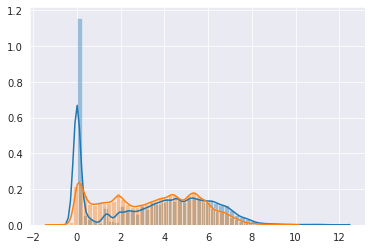

In [29]:
target_meter = 3
X_train, y_train = create_X_y(df_train, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=num_rounds,
                                       lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof3 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof3 * len(y_train)

del X_train, y_train
gc.collect()

In [30]:
##oof Scores

print ('oof score meter0 =', np.sqrt(oof0))
print ('oof score meter1 =', np.sqrt(oof1))
print ('oof score meter2 =', np.sqrt(oof2))
print ('oof score meter3 =', np.sqrt(oof3))
print ('oof score total  =', np.sqrt(oof_total / len(df_train)))

oof score meter0 = 0.6766381298842329
oof score meter1 = 1.5159824534177218
oof score meter2 = 1.4936226258647058
oof score meter3 = 1.5409319622423685
oof score total  = 1.0848345956036507


In [34]:
models = [models0, models1, models2, models3 ]

picfile = open('models.pkl', 'wb')
pickle.dump(models, picfile)
picfile.close()

picfile = open('le.pkl', 'wb')
pickle.dump(le, picfile)
picfile.close()

In [22]:
del df_train, df_weather_train, df_build
gc.collect()

44

In [9]:
picfile = open('models.pkl', 'rb')
models = pickle.load(picfile)
picfile.close()

picfile = open('le.pkl', 'rb')
le = pickle.load(picfile)
picfile.close()

with open('buildings.pkl', 'rb') as file:
    building_median = pickle.load(file)

In [10]:
df_test = pd.read_csv('test.csv')
df_weather_test = pd.read_csv('weather_test.csv')
df_build = pd.read_csv('building_metadata.csv')

df_test = change_dtype(df_test)
df_weather_test = change_dtype(df_weather_test)

df_test = reduce_mem_usage(df_test)
df_weather_test = reduce_mem_usage(df_weather_test)
df_build= reduce_mem_usage(df_build)

gc.collect()

Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


20

In [11]:
df_test['date'] = df_test['timestamp'].dt.date

In [12]:
df_test["hour"] = df_test["timestamp"].dt.hour
df_test["weekend"] = df_test["timestamp"].dt.weekday
df_test["month"] = df_test["timestamp"].dt.month
df_test["dayofweek"] = df_test["timestamp"].dt.dayofweek
df_test['building_median'] = df_test['building_id'].map(building_median)

In [13]:
df_test.dtypes

row_id                      int32
building_id                 int16
meter                        int8
timestamp          datetime64[ns]
date                       object
hour                        int64
weekend                     int64
month                       int64
dayofweek                   int64
building_median           float16
dtype: object

In [14]:
df_weather_test = df_weather_test.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [15]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission = reduce_mem_usage(sample_submission)

gc.collect()

Mem. usage decreased to 198.83 Mb (68.7% reduction)


22

In [16]:
df_build.primary_use = le.transform(df_build.primary_use)

In [17]:
def create_X(test_df, target_meter):
    
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(df_build, on='building_id', how='left')
    target_test_df = target_test_df.merge(df_weather_test, on=['site_id', 'timestamp'], how='left')
    target_test_df.square_feet = np.log1p(target_test_df.square_feet)
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [18]:
from tqdm import tqdm_notebook as tqdm

In [19]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

iterations 25
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


10

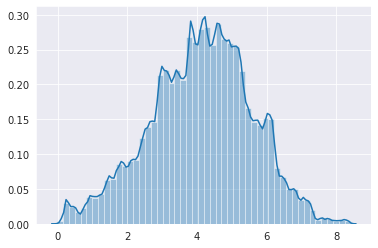

In [20]:
X_test = create_X(df_test, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models[0])

sns.distplot(y_test0)

del X_test
gc.collect()

iterations 9
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


22

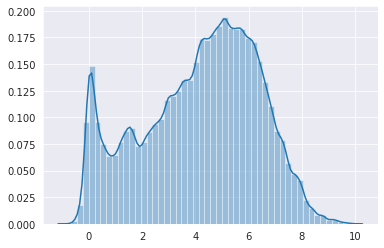

In [22]:
X_test = create_X(df_test, target_meter=1)
gc.collect()

y_test1 = pred(X_test, models[1])
sns.distplot(y_test1)

del X_test
gc.collect()

iterations 6
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


19

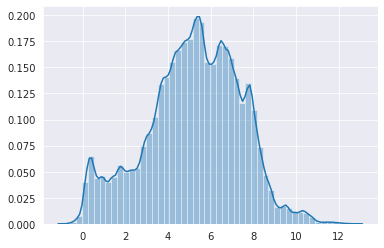

In [23]:
X_test = create_X(df_test, target_meter=2)
gc.collect()

y_test2 = pred(X_test, models[2])
sns.distplot(y_test2)

del X_test
gc.collect()

iterations 3
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


20

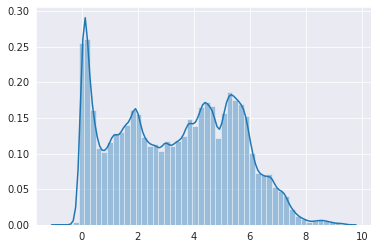

In [24]:
X_test = create_X(df_test, target_meter=3)
gc.collect()

y_test3 = pred(X_test, models[3])
sns.distplot(y_test3)

del X_test
gc.collect()

In [27]:
sample_submission.loc[df_test['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[df_test['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
sample_submission.loc[df_test['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
sample_submission.loc[df_test['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

In [28]:
sample_submission.to_csv('submission1.csv', index=False, float_format='%.4f')

In [33]:
leak_score = 0

leak_df = pd.read_pickle('site0.pkl') 
leak_df['meter_reading'] = leak_df.meter_reading_scraped
leak_df.drop(['meter_reading_original','meter_reading_scraped'], axis=1, inplace=True)
leak_df.fillna(0, inplace=True)
leak_df = leak_df[leak_df.timestamp.dt.year > 2016]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values

sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

for bid in leak_df.building_id.unique():
    temp_df = leak_df[(leak_df.building_id == bid)]
    for m in temp_df.meter.unique():
        v0 = sample_submission.loc[(df_test.building_id == bid)&(df_test.meter==m), 'meter_reading'].values
        v1 = temp_df[temp_df.meter==m].meter_reading.values
        
        leak_score += mean_squared_error(np.log1p(v0), np.log1p(v1)) * len(v0)
        
        sample_submission.loc[(df_test.building_id == bid)&(df_test.meter==m), 'meter_reading'] = temp_df[temp_df.meter==m].meter_reading.values

In [34]:
sample_submission.to_csv('submission2.csv', index=False, float_format='%.4f')

In [36]:
sample_submission['meter_reading'].max()

3298645.6437743423